<a href="https://colab.research.google.com/github/Dkepffl/2022-2-ESAA/blob/main/Assignment/Assignment221205_Keras4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PART 04 합성곱 신경망(CNN)**

### **04 위성 이미지 분류**


#### | **4-1 텐서플로 데이터셋 로드**
- **EuroSAT 데이터셋** : 인공위성에서 지표면을 촬영한 이미지와 토지이용분류(Land Use and Land Cover) 값이 정리되어 있는 데이터셋
- 텐서플로 데이터셋을 이용하기 위해, `tensorflow_datasets` 라이브러리를 호출한다.

In [48]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

# Tensorflow Datasets 활용
import tensorflow_datasets as tfds

- `load` 함수를 사용하여, EuroSAT 데이터셋을 불러온다.
- '(훈련 셋, 검증 셋), 메타정보' 순으로 정리되어 반환된다.
- `info` 변수에 저장되는 메타 정보는 `with_info=True` 옵션일 때만 불러올 수 있다.
- 데이터를 저장할 위치를 `data_dir` 옵션에 지정하면, 해당 위치에 데이터셋 파일을 저장한다.
- train 데이터만 제공하기 때문에 8:2로 구분하여, 80%는 훈련 데이터셋(`train_ds`), 나머지 20% 데이터는 검증 데이터셋(`valid_ds`)으로 분할하여 저장한다.
- 이미지는 (64, 64, 3) 형태임을 아래와 같이 확인할 수 있다.

In [39]:
# EuroSAT 위성사진 데이터셋 로드

DATA_DIR = "/content/sample_data"   

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                       shuffle_files=True, as_supervised=True, with_info=True, data_dir=DATA_DIR)
print(train_ds)
print(valid_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


- 메타 정보를 할당받은 `info` 변수를 출력하여 데이터셋에 대한 기본 정보를 확인해보자.

In [40]:
# 메타데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='/content/sample_data/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    super

- `show_examples` 함수를 사용하여 샘플 이미지를 메타 정보인 분류 레이블과 함께 화면에 출력해보자.

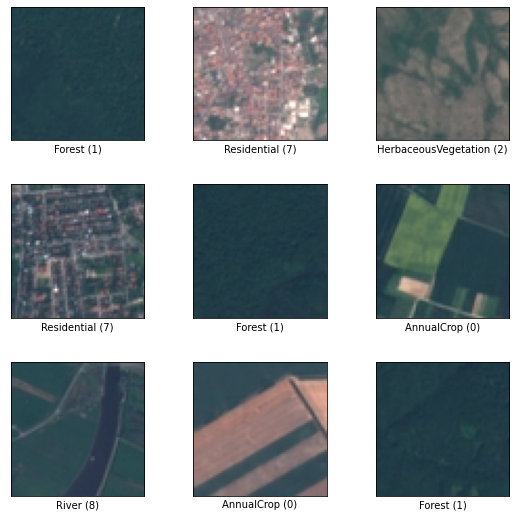

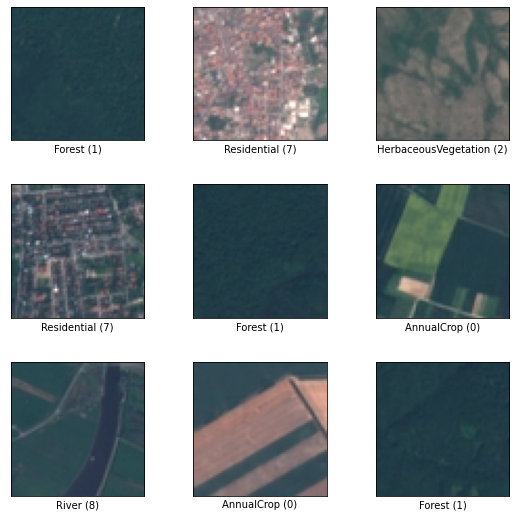

In [41]:
# 데이터 확인
tfds.show_examples(train_ds, info)

- 이번에는 `as_dataframe` 함수를 사용하여, 샘플 이미지 10개를 출력해보자.

image  label
0  [[[56, 84, 121], [56, 85, 119], [67, 94, 124],...      5
1  [[[102, 105, 112], [105, 104, 110], [116, 107,...      7
2  [[[82, 98, 97], [83, 97, 97], [86, 97, 99], [9...      0
3  [[[56, 72, 87], [56, 72, 87], [52, 70, 82], [5...      1
4  [[[219, 154, 126], [218, 153, 125], [220, 154,...      0
5  [[[69, 83, 84], [67, 83, 83], [65, 80, 85], [6...      2
6  [[[28, 52, 76], [28, 52, 76], [31, 51, 75], [3...      9
7  [[[45, 75, 77], [46, 74, 78], [49, 69, 78], [6...      8
8  [[[135, 127, 124], [135, 127, 124], [132, 127,...      2
9  [[[40, 55, 74], [40, 55, 74], [41, 56, 75], [3...      9
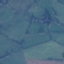
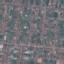
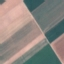
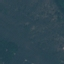
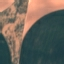
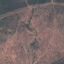
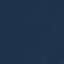
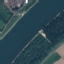
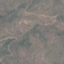
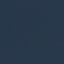

In [42]:
# as_dataframe 사용하여 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info)

- 토지 이용 분류에 해당하는 정답 클래스 개수는 10개이다.
- 앞의 실행 결과를 보면, 클래스 0은 경작지(AnnualCrop), 클래스 9는 바다/호수(SeaLake)를 의미한다.

In [43]:
# 목표 클래스의 개수
NUM_CLASSES = info.features["label"].num_classes
print(NUM_CLASSES)

10


- 클래스를 의미하는 숫자 레이블을 메타 데이터의 문자열로 변환할 수 있다.
- 메타 데이터의 `features` 값 중에 label에 해당하는 메타 정보에 `int2str()` 메소드를 적용한다.

In [44]:
# 숫자 레이블을 활용하여 문자열 메타데이터로 변환
print(info.features["label"].int2str(6))

PermanentCrop


#### | **4-2 데이터 전처리**
- 텐서플로 데이터셋을 이용하면 데이터 전처리 과정이 매우 쉽다.
- 텐서플로 연산은 float32 숫자 값을 사용하기 때문에, cast 함수를 사용하여 자료형을 float32로 변환한다.
- 입력 이미지는 0~255 범위의 픽셀 값을 갖기 때문에 255로 나눠 정규화한다. 이 과정을 처리하는 `preprocess_data` 함수를 정의한다.
- `map` 함수는 사용자 정의 함수를 매핑하여 텐서플로 데이터셋에 적용하는 메소드로 전처리 과정에 매우 유용하다. `num_parallel_calls` 옵션을 오토튠(AUTOTUNE)으로 지정하면 텐서플로 병렬연산 처리를 자동으로 최적화한다.
- 정규화 변환을 마친 데이터셋에 `shuffle()` 메소드를 적용하여 순서를 랜덤하게 섞어 준다. 모델의 일반화된 성능을 높이기 위해 데이터 입력 순서에 무작위성을 부여하는 것이다.
- `prefetch()` 메소드는 모델이 훈련을 진행하는 동안 다음에 입력할 데이터를 불러와 미리 전처리 하도록 시스템을 조율한다.

In [45]:
# 데이터 전처리 파이프라인 
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화, float32 변환
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) 

#### | **4-3 모델 훈련 검증**
- 배치 정규화, 합성곱, 풀링 레이어로 구성된 유닛을 2개 연결하고, Dense 레이어와 Dropout으로 구성된 최종 분류기를 갖는 딥러닝 모델을 Sequential API로 생성한다.

In [46]:
# Sequential API를 사용하여 샘플 모델 생성
def build_model():

    model = tf.keras.Sequential([

        # Convolution 층 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Classifier 출력층 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dropout(0.3),  
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.3),              
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

model = build_model()

- 예측 클래스가 10개인 다중 분류 문제에 맞게 손실함수와 평가 지표를 설정하고, 모델을 50 epoch 훈련시킨다.

In [47]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_data, 
                    validation_data=valid_data, 
                    epochs=50)                   

Epoch 1/50
338/338 [==============================] - 139s 408ms/step - loss: 1.5926 - accuracy: 0.4581 - val_loss: 1.3975 - val_accuracy: 0.5474
Epoch 2/50
338/338 [==============================] - 129s 381ms/step - loss: 1.1813 - accuracy: 0.5945 - val_loss: 0.9676 - val_accuracy: 0.6917
Epoch 3/50
338/338 [==============================] - 108s 319ms/step - loss: 1.0247 - accuracy: 0.6441 - val_loss: 0.7595 - val_accuracy: 0.7454
Epoch 4/50
338/338 [==============================] - 115s 341ms/step - loss: 0.8959 - accuracy: 0.6874 - val_loss: 0.6583 - val_accuracy: 0.7841
Epoch 5/50
338/338 [==============================] - 113s 333ms/step - loss: 0.7901 - accuracy: 0.7311 - val_loss: 0.6111 - val_accuracy: 0.7944
Epoch 6/50
338/338 [==============================] - 116s 342ms/step - loss: 0.7128 - accuracy: 0.7565 - val_loss: 0.6392 - val_accuracy: 0.7809
Epoch 7/50
338/338 [==============================] - 115s 342ms/step - loss: 0.6476 - accuracy: 0.7874 - val_loss: 0.5270 -

In [13]:
# 손실함수, 정확도 그래프 그리기 

def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

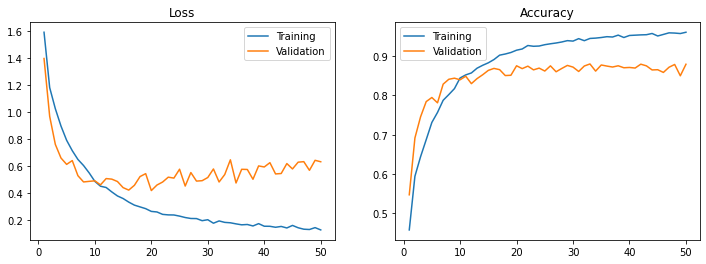

In [49]:
plot_loss_acc(history, 50)

- 모델은 10 epoch까지는 빠른 속도로 훈련이 진행되며 손실함수가 급격하게 감소한다.
- 하지만 그 이후로는 검증 데이터셋에 대한 손실함수가 더 이상 줄어들지 않으면서 과대적합되기 시작한다.

#### | **4-4 데이터 증강(Data Augmentation)**
- 과대적합을 해소하기 위해 배치 정규화, Dropout 등을 적용하였으나 과대적합이 발생하였다.
- 이미지 분류 문제에서 과대적합을 해소하고, 모델의 일반화된 Robust한 성능을 확보하는 기법인 **데이터 증강(Data Augmentation)** 기법에 대해 알아보자.
- 이는 이미지 데이터에 여러 가지 변화를 주어 훈련 데이터의 다양성을 확보하는 방법이다.
- 먼저 EuroSAT 데이터셋 중 하나의 샘플 이미지를 선택하여 시각화해보자.

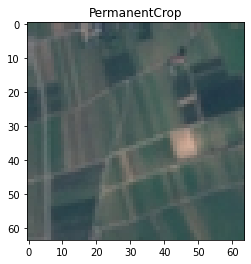

In [21]:
# 샘플 이미지
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features["label"].int2str(label));

- 샘플 이미지에 변화를 주기 전과 후의 이미지를 비교할 수 있는 시각화 함수를 정의한다.

In [22]:
# 데이터 증강 전후를 비교하는 시각화 함수를 정의
def plot_augmentation(original, augmented):

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].imshow(original)
    axes[0].set_title('Original')

    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')

    plt.show()

- `tf.image` 모듈의 `flip_left_right` 함수를 사용하여 이미지를 좌우 방향으로 뒤집었다.

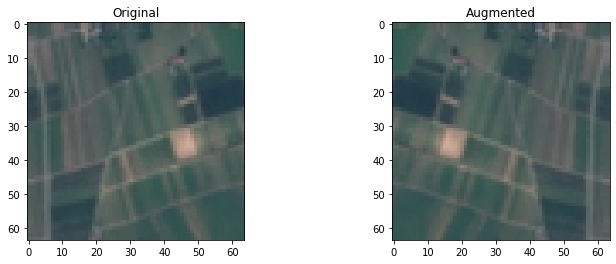

In [23]:
# 좌우 뒤집기 
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

- `tf.image` 모듈의 `flip_up_down` 함수를 사용하여 이미지를 상하 방향으로 뒤집었다.

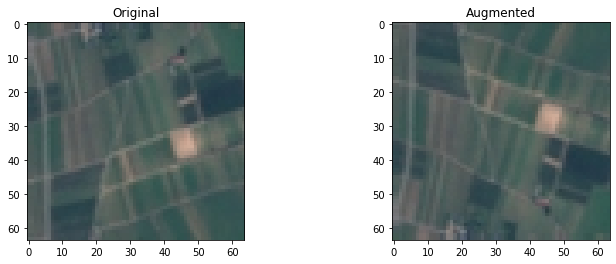

In [24]:
# 상하 뒤집기 
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

- `rot90` 함수를 사용하면 이미지를 반시계 방향으로 90도 회전할 수 있다.

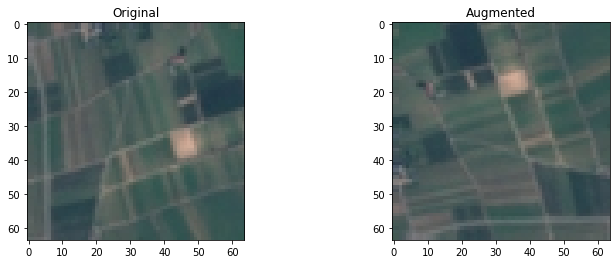

In [25]:
# 회전 
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

- `transpose` 함수는 이미지 텐서 행렬의 행과 열의 위치를 바꿔준다.

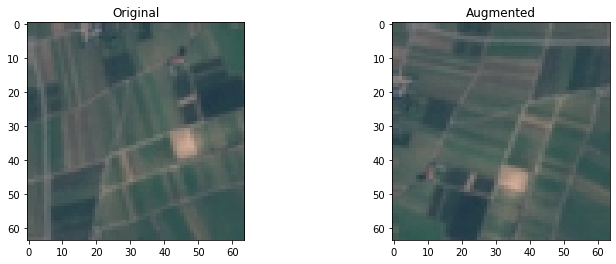

In [26]:
# transpose 
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

- `central_crop` 함수는 이미지의 중심에서 일정 부분을 잘라낸다.

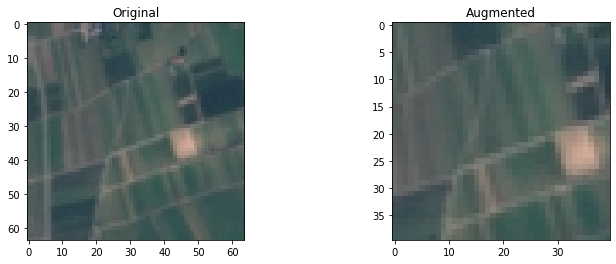

In [27]:
# 이미지 자르기 1
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

- `resize_with_crop_or_pad` 함수를 사용하여, 원본 이미지를 키우고, `random_crop` 함수를 이용하여 이미지를 원본 크기와 같게 자르면 원본 이미지가 상하좌우 랜덤함 방향으로 이동한다.

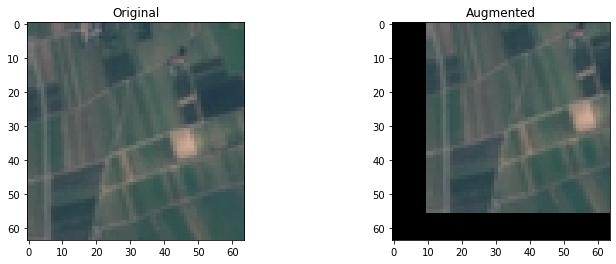

In [28]:
# 이미지 자르기 2 
img = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20) # 사이즈 키우기
crop2 = tf.image.random_crop(img, size=[64, 64, 3])
plot_augmentation(image, crop2)

- 이미지의 밝기도 `adjust_brightness`를 이용하여 조정할 수 있다.

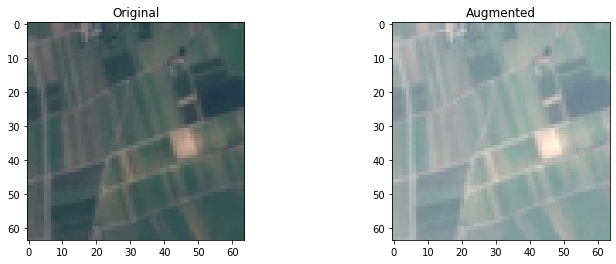

In [29]:
# 이미지 밝기 
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

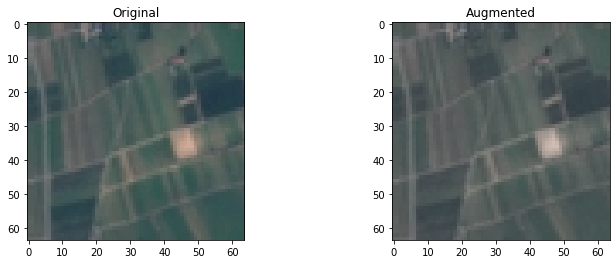

In [30]:
# 이미지 채도 
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

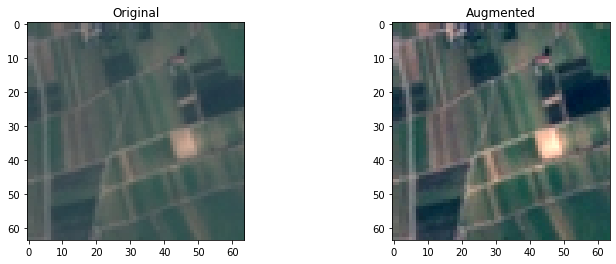

In [31]:
# 이미지 대비  
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

- 앞서 다룬 여러 기법 중 몇 가지를 선택하여 데이터 증강 및 전처리를 수행하는 `data_augmentation` 함수를 정의해보자.
- 이미지 증강 효과에 랜덤성을 부여하기 위해, `tf.image` 모듈에서 지원하는 함수 중 `random_`으로 시작하는 함수를 적용하였다.
- `map` 함수로 원본 데이터셋에 적용하고, 미니 배치로 만들어 주었다.

In [32]:
# 이미지 증강 전처리
def data_augmentation(image, label):

    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_flip_up_down(image) # 상하 반전    
    image = tf.image.random_brightness(image, max_delta=0.3) # 밝기 변화 
    image = tf.image.random_crop(image, size=[64, 64, 3])

    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화

    return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE) # 원본 데이터셋에 적용
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # 미니 배치로
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) 

print(train_aug)
print(valid_aug)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


- 모델 객체를 생성하고, 컴파일을 실행한 후, 50 epoch 동안 훈련시키자.

In [33]:
# 모델 생성
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
aug_history = aug_model.fit(train_aug, 
                            validation_data=valid_aug, 
                            epochs=50)

Epoch 1/50
338/338 [==============================] - 107s 316ms/step - loss: 1.8748 - accuracy: 0.3120 - val_loss: 1.7218 - val_accuracy: 0.4044
Epoch 2/50
338/338 [==============================] - 109s 321ms/step - loss: 1.5482 - accuracy: 0.4120 - val_loss: 1.3027 - val_accuracy: 0.4963
Epoch 3/50
338/338 [==============================] - 107s 318ms/step - loss: 1.4145 - accuracy: 0.4702 - val_loss: 1.2372 - val_accuracy: 0.5661
Epoch 4/50
338/338 [==============================] - 107s 317ms/step - loss: 1.3359 - accuracy: 0.4994 - val_loss: 1.1547 - val_accuracy: 0.6009
Epoch 5/50
338/338 [==============================] - 108s 319ms/step - loss: 1.2646 - accuracy: 0.5320 - val_loss: 0.9737 - val_accuracy: 0.6687
Epoch 6/50
338/338 [==============================] - 108s 318ms/step - loss: 1.1915 - accuracy: 0.5706 - val_loss: 0.9402 - val_accuracy: 0.6733
Epoch 7/50
338/338 [==============================] - 107s 315ms/step - loss: 1.0943 - accuracy: 0.6054 - val_loss: 0.9085 -

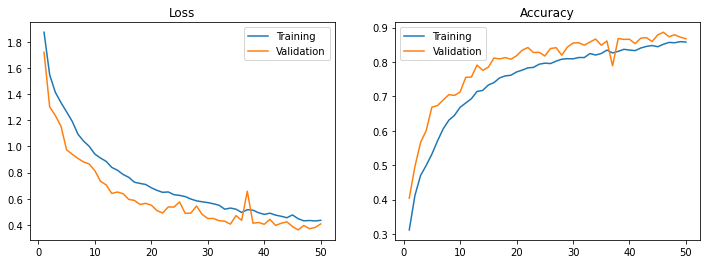

In [58]:
# 손실함수, 정확도 그래프 그리기 
plot_loss_acc(aug_history, 50)

- 데이터 증강을 하기 전과 모델의 성능 자체는 큰 차이가 없다.
- 하지만 손실함수와 정확도 그래프를 보면, 과대적합 문제가 상당히 해소된 것을 알 수 있다.

#### | **4-5 ResNet 사전 학습 모델**
- 이번에는 ResNet 모델을 활용해서 위성 이미지를 분류해보자.
- 해당 모델은 이미지넷 경진 대회에서 우승한 모델로 우수한 성능을 갖는데, 이처럼 사전에 방대한 이미지로 훈련을 받은 딥러닝 모델의 구조와 가중치를 그대로 가져오고, 모델의 끝에 위치하는 Top 층에 위성 이미지를 분류할 수 있는 최종 분류기를 추가하는 방식으로 모델을 구성할 수 있다.
- 이를 앞에서 배웠듯 **전이 학습(Transfer Learning)**이라고 한다.

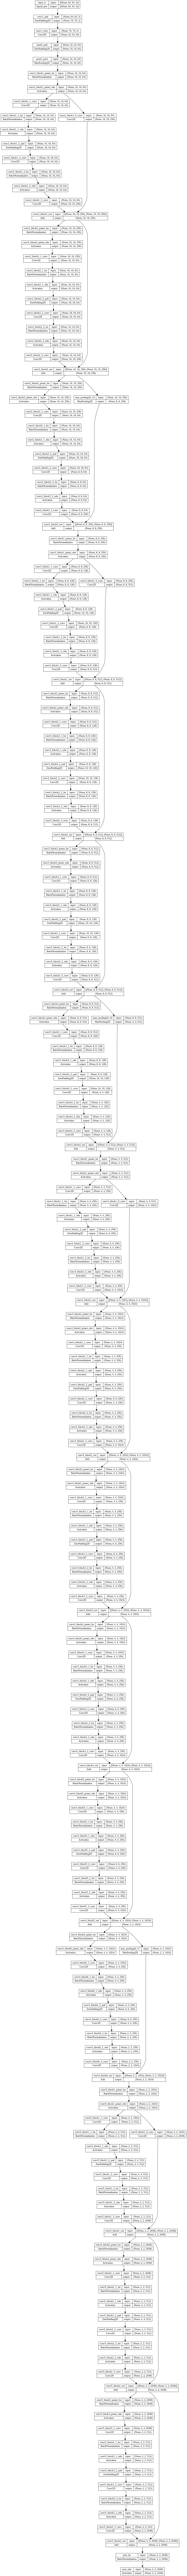

In [8]:
# Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False, 
                               weights='imagenet',
                               input_shape=[64, 64, 3])

# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

# 모델 구조 시각화
from tensorflow.keras.utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')

- 최종적으로 10개 클래스에 대해 다중 분류할 수 있도록 Dense 레이어의 노드 개수와 softmax 활성화 함수를 지정해준다.

In [19]:
# Top 층에 Classifier 추가
def build_trainsfer_classifier():

    model = tf.keras.Sequential([

        # Pre-trained Base 
        pre_trained_base,
        # Classifier 출력층 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dropout(0.3),  
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.3),              
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

# 모델 구조
tc_model = build_trainsfer_classifier()    
tc_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                6

### **05 개/고양이 분류**

#### | **5-1 분석 준비**

##### **5-1-1 데이터셋 다운로드**
- 캐글에서 제공하는 'Cat and Dog' 데이터셋을 이용한다.
- 실무에서 주로 다루는 이미지 파일의 용량이 크거나 파일 개수가 많아, 컴퓨터 메모리 또는 그래픽 카드 메모리가 부족한 상황이 발생한다. 이를 해결하기 위해, 전체 데이터셋을 전부 모델에 입력할 때까지 배치 단위로 읽어오고 주입하는 과정을 반복한다.
- 텐서플로 케라스는 이 과정을 ImageDataGenerator 함수로 지원한다.

##### **5-1-2 라이브러리 불러오기**

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pylab as plt

##### **5-1-3 구글 드라이브 어마운트**

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


##### **5-1-4 압축 파일 해제**

In [3]:
# 압축 파일의 위치 (구글 드라이브 - 내 드라이브 위치)  
drive_path = '/content/drive/MyDrive/'
source_filename = drive_path + '2022-2 ESAA/Data/cat_and_dog.zip'

# 저장할 경로 
extract_folder = "dataset/"   # 코랩 환경에 임시 저장 

# 압축 해제 
import shutil
shutil.unpack_archive(source_filename, extract_folder) 

In [4]:
# 훈련 셋, 검증 셋 저장위치 지정
train_dir = extract_folder + "training_set/training_set"
valid_dir = extract_folder + "test_set/test_set"
print(train_dir)
print(valid_dir)

dataset/training_set/training_set
dataset/test_set/test_set


#### | **5-2 모델 학습**

##### **5-2-1 ImageDataGenerator**
- 케라스 ImageDataGenerator 클래스 함수를 실행하고 `rescale` 옵션을 지정하여, 이미지의 각 픽셀 값을 0~1 범위로 정규화한다.
- 생성된 ImageDataGenerator 객체는 `image_gen` 변수에 할당한다. 

In [5]:
# 이미지 데이터 제너레이터 정의 (Augmentation 미적용)
image_gen = ImageDataGenerator(rescale=(1/255.))
image_gen

##### **5-2-2 flow_from_directory 함수**
- `flow_from_directory` 함수를 적용하면 지정한 폴더에서 이미지를 가져와 반복이 가능하도록 데이터셋을 처리한다.
- 데이터셋이 저장되어 있는 위치, 배치를 구성하는 이미지 개수, 저장될 이미지의 픽셀 사이즈 등을 지정한다.

In [6]:
# flow_from_directory 함수로 폴더에서 이미지 가져와서 제너레이터 객체로 정리 
train_gen = image_gen.flow_from_directory(train_dir, # 데이터셋이 저장되어 있는 위치
                                          batch_size=32, # 배치를 구성하는 이미지 개수
                                          target_size=(224, 224), # 저장될 이미지의 픽셀 사이즈(세로, 가로)
                                          classes=['cats','dogs'], # 클래스 레이블
                                          class_mode = 'binary', # 이진 분류 문제이므로 'binary'
                                          seed=2020) # 랜덤 시드 값

valid_gen = image_gen.flow_from_directory(valid_dir,                                          
                                          batch_size=32, 
                                          target_size=(224, 224),   
                                          classes=['cats','dogs'], 
                                          class_mode = 'binary',
                                          seed=2020)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


- 한 개의 배치를 선택해 그 안에 있는 32개의 이미지를 정답 클래스 레이블과 함께 출력하면 다음과 같다. 

<ipython-input-7-4e35875d3335>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title(class_labels[labels[i].astype(np.int)])


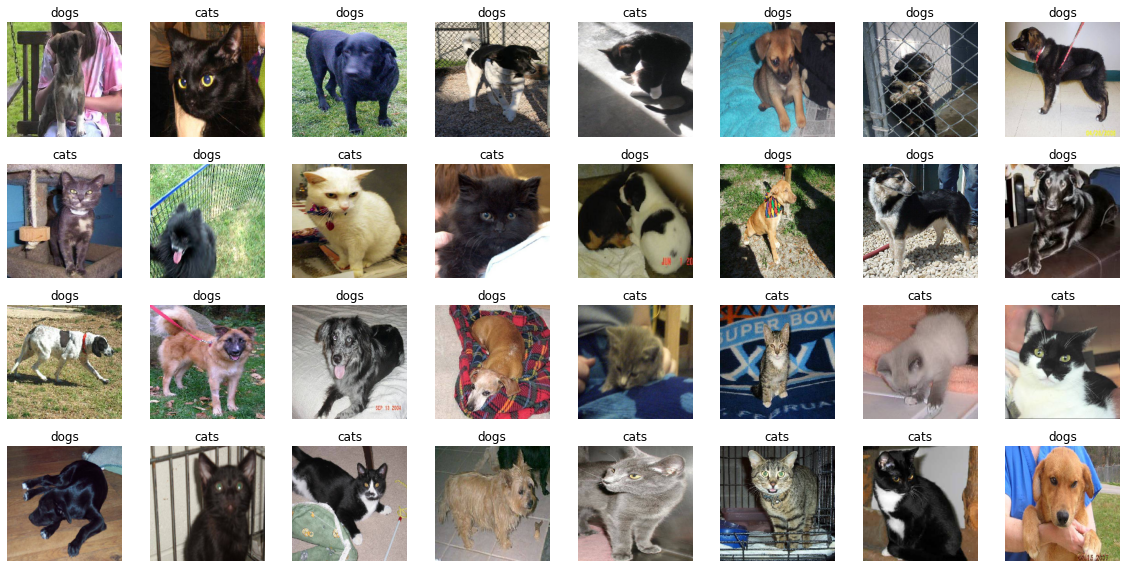

In [7]:
# 샘플 이미지 출력
class_labels = ['cats', 'dogs']
batch = next(train_gen)
images, labels = batch[0], batch[1]

plt.figure(figsize=(16, 8))
for i in range(32):
    
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(images[i])
    plt.title(class_labels[labels[i].astype(np.int)])
    plt.axis("off")
plt.tight_layout()
plt.show()

##### **5-2-3 모델 훈련**
- '배치 정규화-합성곱-풀링'으로 구성된 유닛을 3개 반복하여, 이미지로부터 다양한 피처를 추출하고, 최종 분류기로 Dense 레이어를 사용하는 이진 분류 모델을 정의한다.
- 최종 출력 레이어는 노드가 1개이고, 활성화 함수로 'sigmoid'를 적용한다.

In [8]:
# Sequential API를 사용하여 샘플 모델 생성

def build_model():

    model = tf.keras.Sequential([

        # Convolution 층 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Classifier 출력층 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'), 
        tf.keras.layers.Dropout(0.3),              
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    return model

model = build_model()

- 옵티마이저, 손실함수를 지정한다.
- 모델을 컴파일하고, 20 epoch 동안 훈련시킨다.

In [9]:
# 모델 컴파일
model.compile(optimizer=tf.optimizers.Adam(lr=0.001), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_gen, validation_data=valid_gen, epochs=20)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


251/251 [==============================] - 1121s 4s/step - loss: 2.4458 - accuracy: 0.5410 - val_loss: 0.6878 - val_accuracy: 0.5002
Epoch 2/20
251/251 [==============================] - 1137s 5s/step - loss: 0.6404 - accuracy: 0.6026 - val_loss: 0.6167 - val_accuracy: 0.6520
Epoch 3/20
251/251 [==============================] - 1143s 5s/step - loss: 0.6031 - accuracy: 0.6520 - val_loss: 0.5786 - val_accuracy: 0.6723
Epoch 4/20
251/251 [==============================] - 1137s 5s/step - loss: 0.5777 - accuracy: 0.6657 - val_loss: 0.5686 - val_accuracy: 0.7113
Epoch 5/20
251/251 [==============================] - 1137s 5s/step - loss: 0.5627 - accuracy: 0.6859 - val_loss: 0.5511 - val_accuracy: 0.7123
Epoch 6/20
251/251 [==============================] - 1139s 5s/step - loss: 0.5452 - accuracy: 0.7018 - val_loss: 0.5369 - val_accuracy: 0.7158
Epoch 7/20
251/251 [==============================] - 1138s 5s/step - loss: 0.5142 - accuracy: 0.7138 - val_loss: 0.5166 - val_accuracy: 0.7410
Epo

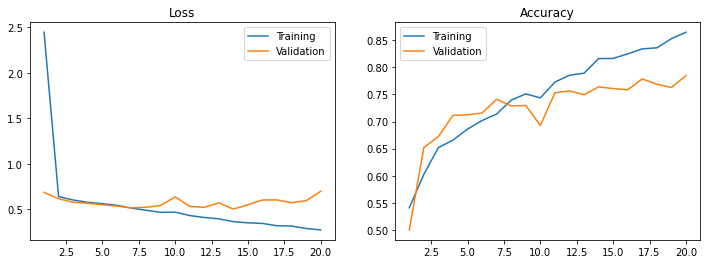

In [14]:
plot_loss_acc(history, 20)

##### **5-2-4 데이터 증강**
- ImageDataGenerator를 사용하면 다양한 데이터 증강 기법을 클래스 함수의 매개변수 속성으로 지정할 수 있어 편리하다.
- 좌우 방향으로 뒤집는 `horizontal_flip` 속성을 지정하고, 회전은 최대 30도롤 지정한다.
- 이미지를 반시계 방향으로 밀리도록 변형하는 `shear_range` 속성과 이미지를 줌으로 확대하는 `zoom_range` 속성도 추가한다.
- 이미지 파일이 저장되어 있는 폴더에서 이미지를 배치 크기 단위로 불러와 데이터 증강 기법을 적용하고 목표 크기에 맞춰 미니 배치를 구성한다.

In [15]:
# 이미지 데이터 제너레이터 정의 (Augmentation 적용)
image_gen_aug = ImageDataGenerator(rescale=1/255., 
                                   horizontal_flip=True,
                                   rotation_range=35,                                
                                   zoom_range=0.2)

# flow_from_directory 함수로 폴더에서 이미지 가져와서 제너레이터 객체로 정리 
train_gen_aug = image_gen_aug.flow_from_directory(train_dir, 
                                                  batch_size=32, 
                                                  target_size=(224,224),   
                                                  classes=['cats','dogs'], 
                                                  class_mode = 'binary', 
                                                  seed=2020)

valid_gen_aug = image_gen_aug.flow_from_directory(valid_dir,  
                                                  batch_size=32, 
                                                  target_size=(224,224),   
                                                  classes=['cats','dogs'], 
                                                  class_mode = 'binary', 
                                                  seed=2020)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


- 그리고 모델 객체를 생성한 후 훈련시킨다.

In [ ]:
# 모델 생성
model_aug = build_model()

# 모델 컴파일
model_aug.compile(optimizer=tf.optimizers.Adam(lr=0.001),  
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# 모델 훈련
history_aug = model_aug.fit(train_gen_aug, validation_data=valid_gen_aug, epochs=40)

Epoch 1/40
251/251 [==============================] - 1251s 5s/step - loss: 2.0307 - accuracy: 0.6121 - val_loss: 0.6585 - val_accuracy: 0.6134
Epoch 2/40
251/251 [==============================] - 1231s 5s/step - loss: 0.6084 - accuracy: 0.6666 - val_loss: 0.5987 - val_accuracy: 0.6569
Epoch 3/40
251/251 [==============================] - 1232s 5s/step - loss: 0.5943 - accuracy: 0.6737 - val_loss: 0.5685 - val_accuracy: 0.6881
Epoch 4/40
251/251 [==============================] - 1218s 5s/step - loss: 0.5891 - accuracy: 0.6773 - val_loss: 0.5755 - val_accuracy: 0.6792
Epoch 5/40
251/251 [==============================] - 1223s 5s/step - loss: 0.5724 - accuracy: 0.6971 - val_loss: 0.5405 - val_accuracy: 0.7103
Epoch 6/40
251/251 [==============================] - 1213s 5s/step - loss: 0.5645 - accuracy: 0.6941 - val_loss: 0.5525 - val_accuracy: 0.7197
Epoch 7/40
 49/251 [====>.........................] - ETA: 15:15 - loss: 0.5892 - accuracy: 0.6709